In [18]:
# Sentiment labeling (Positive, Negative, Neutral) 

import pandas as pd
import torch
from transformers import pipeline
from datetime import datetime

df = pd.read_csv("test(in).csv")
df["text"] = df["Subject"].fillna('') + ". " + df["body"].fillna('')
df["date"] = pd.to_datetime(df["date"], errors='coerce')

#  Loading HuggingFace sentiment classifier with PyTorch explicitly
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt"  # ⬅️ FORCE PyTorch backend
)

#  Defining function to classify sentiment
def classify_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])[0]
        return 'Positive' if result['label'] == 'POSITIVE' else 'Negative'
    except:
        return 'Neutral'

# Applying sentiment classifier
df["sentiment"] = df["text"].apply(classify_sentiment)

# Saving result
df.to_csv("labeled_employee_data.csv", index=False)

df[["from", "date", "sentiment"]].head()


Device set to use mps:0


,from,date,sentiment
0,sally.beck@enron.com,2010-05-10,Negative
1,eric.bass@enron.com,2010-07-29,Negative
2,sally.beck@enron.com,2011-07-25,Negative
3,johnny.palmer@enron.com,2010-03-25,Negative
4,lydia.delgado@enron.com,2011-05-21,Positive


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


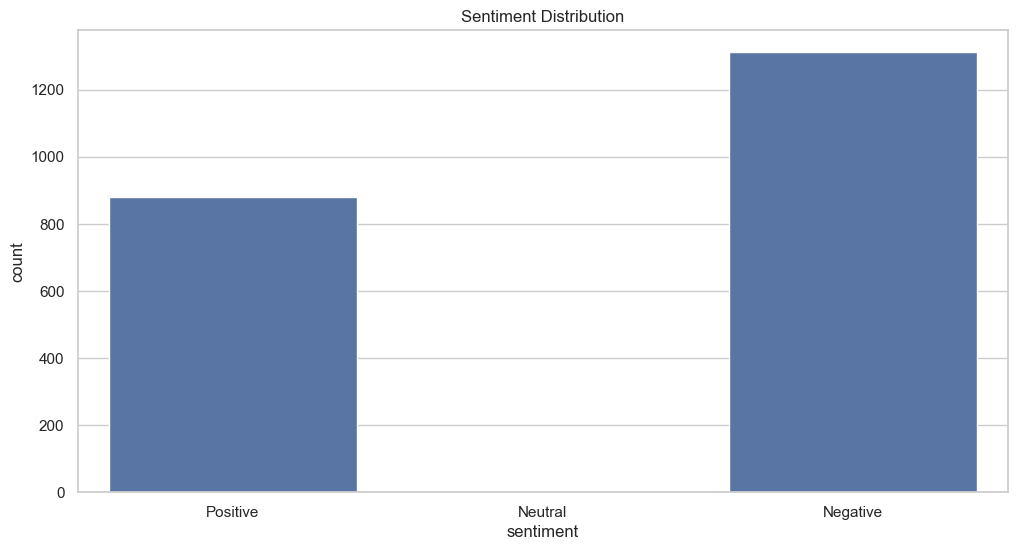

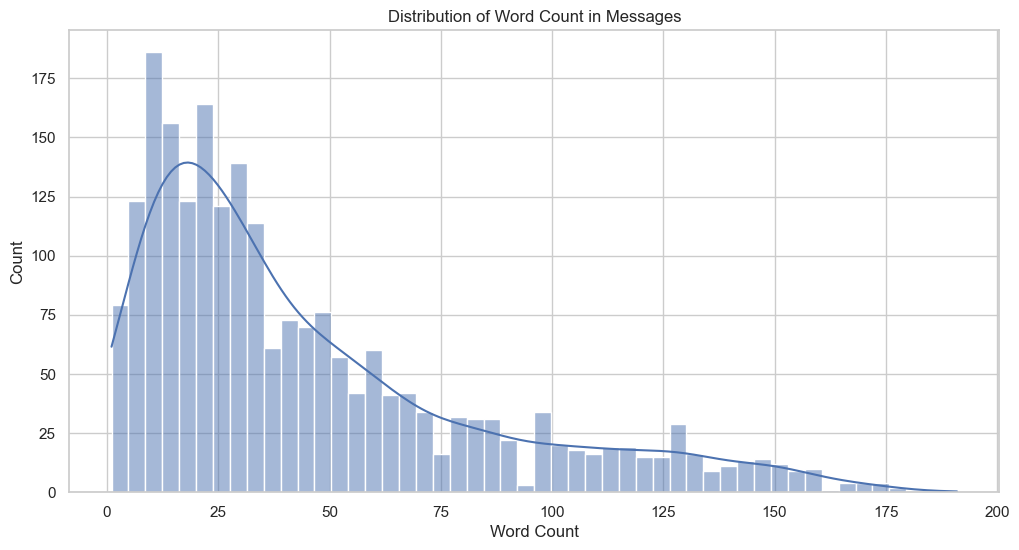

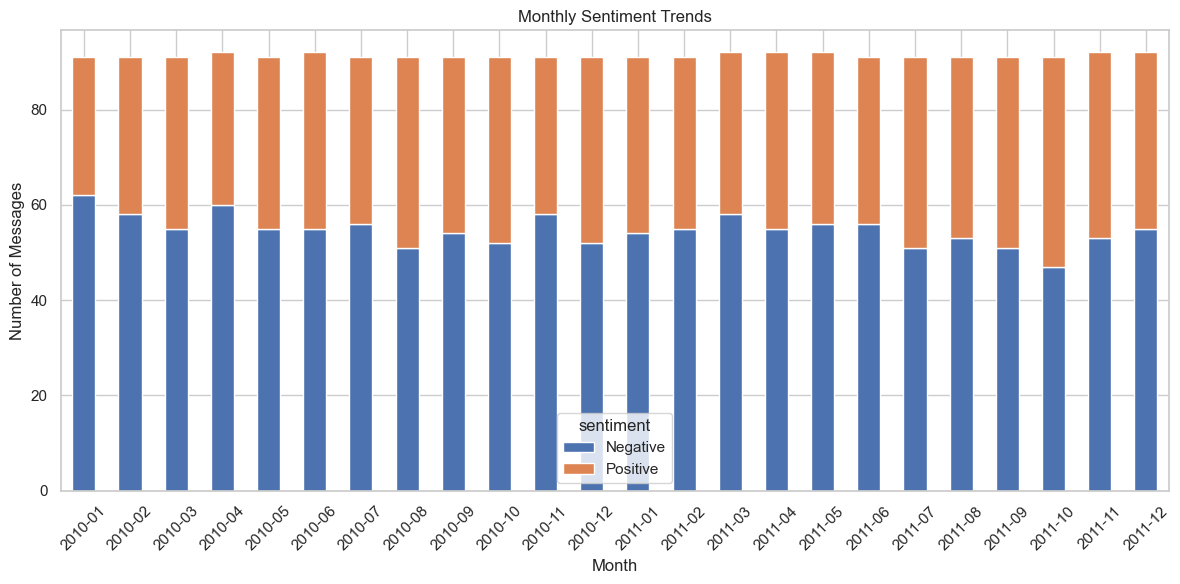

Average Length Stats by Sentiment:
            word_count  char_count
sentiment                        
Negative    47.270579  304.721799
Positive    42.218430  257.349261


In [19]:
# EDA and data visualizations 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setting visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Loading labeled data (in case you're starting a new notebook)
df = pd.read_csv("labeled_employee_data.csv")
df["date"] = pd.to_datetime(df["date"], errors='coerce')

# ➕ Add word and character counts
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
df["char_count"] = df["text"].apply(lambda x: len(str(x)))

# 1. Sentiment distribution
sns.countplot(data=df, x="sentiment", order=["Positive", "Neutral", "Negative"])
plt.title("Sentiment Distribution")
plt.show()

# 2. Word count distribution
sns.histplot(df["word_count"], bins=50, kde=True)
plt.title("Distribution of Word Count in Messages")
plt.xlabel("Word Count")
plt.show()

# 3. Message trend over time
df["month"] = df["date"].dt.to_period("M")
monthly_counts = df.groupby(["month", "sentiment"]).size().unstack().fillna(0)
monthly_counts.plot(kind="bar", stacked=True)
plt.title("Monthly Sentiment Trends")
plt.ylabel("Number of Messages")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Average message length by sentiment
avg_len = df.groupby("sentiment")[["word_count", "char_count"]].mean()
print("Average Length Stats by Sentiment:\n", avg_len)


In [22]:
# Monthly sentiment scoring 

#  Converting sentiment labels to numeric scores
score_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
df["sentiment_score"] = df["sentiment"].map(score_map)

# Extracting employee and month
df["month"] = df["date"].dt.to_period("M")  # Period format like '2025-01'

# Grouping by employee and month, sum sentiment scores
monthly_scores = df.groupby(["from", "month"])["sentiment_score"].sum().reset_index()
monthly_scores.rename(columns={"from": "employee", "sentiment_score": "monthly_score"}, inplace=True)

# Saving the results
monthly_scores.to_csv("monthly_employee_scores.csv", index=False)

monthly_scores.head()


,employee,month,monthly_score
0,bobette.riner@ipgdirect.com,2010-01,-2
1,bobette.riner@ipgdirect.com,2010-02,-4
2,bobette.riner@ipgdirect.com,2010-03,-3
3,bobette.riner@ipgdirect.com,2010-04,-2
4,bobette.riner@ipgdirect.com,2010-05,2


In [24]:
#Employee ranking 

# Loading the monthly scores 
monthly_scores = pd.read_csv("monthly_employee_scores.csv")
monthly_scores["month"] = pd.PeriodIndex(monthly_scores["month"], freq="M")

# Top 3 Positive Employees per month
top_positive = (
    monthly_scores.sort_values(by=["month", "monthly_score", "employee"], ascending=[True, False, True])
    .groupby("month")
    .head(3)
)
top_positive["rank_type"] = "Top Positive"

# Top 3 Negative Employees per month
top_negative = (
    monthly_scores.sort_values(by=["month", "monthly_score", "employee"], ascending=[True, True, True])
    .groupby("month")
    .head(3)
)
top_negative["rank_type"] = "Top Negative"

# Combine and sort
employee_ranking = pd.concat([top_positive, top_negative]).sort_values(by=["month", "rank_type", "monthly_score"], ascending=[True, True, False])


employee_ranking.to_csv("employee_monthly_rankings.csv", index=False)


employee_ranking.head(10)


,employee,month,monthly_score,rank_type
24,don.baughman@enron.com,2010-01,-5,Top Negative
144,lydia.delgado@enron.com,2010-01,-5,Top Negative
120,kayne.coulter@enron.com,2010-01,-6,Top Negative
72,john.arnold@enron.com,2010-01,-1,Top Positive
192,rhonda.denton@enron.com,2010-01,-1,Top Positive
0,bobette.riner@ipgdirect.com,2010-01,-2,Top Positive
1,bobette.riner@ipgdirect.com,2010-02,-4,Top Negative
73,john.arnold@enron.com,2010-02,-8,Top Negative
121,kayne.coulter@enron.com,2010-02,-8,Top Negative
145,lydia.delgado@enron.com,2010-02,1,Top Positive


In [26]:
# Flight risk identification 

# Load full labeled dataset 
df = pd.read_csv("labeled_employee_data.csv")
df["date"] = pd.to_datetime(df["date"], errors='coerce')
df = df.sort_values(by=["from", "date"])

# Filter only negative messages
negative_msgs = df[df["sentiment"] == "Negative"].copy()

# Rolling 30-day window count per employee
risk_employees = set()

for emp, group in negative_msgs.groupby("from"):
    dates = group["date"].sort_values().reset_index(drop=True)
    for i in range(len(dates)):
        # Count how many fall in the current 30-day window
        window_start = dates[i]
        window_end = window_start + pd.Timedelta(days=30)
        count_in_window = dates[(dates >= window_start) & (dates <= window_end)].count()
        if count_in_window >= 4:
            risk_employees.add(emp)
            break  # Only need to flag once

# Create flight risk DataFrame
flight_risk_df = pd.DataFrame({"employee": list(risk_employees)})
flight_risk_df["flight_risk"] = True


flight_risk_df.to_csv("flight_risk_employees.csv", index=False)


flight_risk_df.head()


,employee,flight_risk
0,lydia.delgado@enron.com,True
1,sally.beck@enron.com,True
2,johnny.palmer@enron.com,True
3,don.baughman@enron.com,True
4,eric.bass@enron.com,True


In [37]:
#Linear regression model for sentiment trends
                       
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("labeled_employee_data.csv")
df["date"] = pd.to_datetime(df["date"], errors='coerce')
df["month"] = df["date"].dt.to_period("M")
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
df["sentiment_score"] = df["sentiment"].map({"Positive": 1, "Neutral": 0, "Negative": -1})

# Group by employee and month
agg_df = df.groupby(["from", "month"]).agg(
    monthly_score=("sentiment_score", "sum"),
    msg_count=("sentiment_score", "count"),
    avg_word_count=("word_count", "mean"),
    avg_sentiment=("sentiment_score", "mean"),
    pos_pct=("sentiment", lambda x: (x == "Positive").mean()),
    neg_pct=("sentiment", lambda x: (x == "Negative").mean())
).reset_index().rename(columns={"from": "employee"})

# Drop NaNs
agg_df = agg_df.dropna()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Features and label
features = ["msg_count", "avg_word_count", "avg_sentiment", "pos_pct", "neg_pct"]
X = agg_df[features]
y = agg_df["monthly_score"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("📊 Model Performance:")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# coefficients
coef_df = pd.DataFrame({"Feature": features, "Coefficient": model.coef_})
print("\nFeature Importance:\n", coef_df)


📊 Model Performance:
R² Score: 0.5484671927215263
MAE: 1.4888852658812815

Feature Importance:
           Feature  Coefficient
0       msg_count    -0.198727
1  avg_word_count     0.005465
2   avg_sentiment     2.715936
3         pos_pct     1.357968
4         neg_pct    -1.357968
